# Rainfall Observations

- **Author**: Daniel Rothenberg (daniel@climacell.co)
- **Last Revised**: November 7, 2017

In this notebook we look at the spatio-temporal characteristics of rainfall for test-cases which have been saved for the purpose of evaluating our NowCast algorithms.

In [7]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])
import seaborn as sns

import numpy as np
import pandas as pd
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The IEM NEXRAD composite (n0q) uses [an 8-bit colormapping](https://mesonet.agron.iastate.edu/docs/nexrad_composites/) such that the values [-32, 90] dBZ are mapped at 0.5 dBZ increments. Although it isn't specified, I'm going to assume that the MRMS LCREF field is mapped the same way. For the precipitation rates, we don't have a great indication of what is used, but we can run with [the approximate mapping here](https://mesonet.agron.iastate.edu/rainfall/):

- 1-100: dx = 0.25 mm
- 101-180: dx = 1.25 mm 
- 181-254: dx = 5 mm
- 255: missing

To derive rain intensity from the reflectivity, we'll use the Marshall-Palmer distribution:

$$ R = \left(\frac{1}{200}\times10^{\mathrm{dBZ}/10}\right)^{1/1.6} $$

Pre-load and process the data for a specific test case.

In [3]:
case = "data/boston_nov_3/"

hrrr = xr.open_dataset(case + "hrrr/hrrr.ensemble.nc", engine='netcdf4')
lon2d = hrrr.lon.values
lat2d = hrrr.lat.values

n0q = xr.open_dataarray(case + "n0q.subset.nc").squeeze()
n0q = n0q.where(n0q > 0)
n0q.values = (-32. + n0q.values*0.5)
n0q_rate = (0.005*np.power(10., n0q/10.))**(1/1.6)

lcref = xr.open_dataarray(case + "lcref.subset.nc").squeeze()
lcref = lcref.where(lcref > 0)
lcref.values = (-32. + lcref.values*0.5)
lcref_rate = (0.005*np.power(10., lcref/10.))**(1/1.6)

a2m = xr.open_dataarray(case + "a2m.subset.nc").squeeze()
a2m = a2m.where(a2m < 255)
_v = a2m.values
_v[_v < 100] = 0. + _v[_v < 100]*0.25
_v[(_v > 100) & (_v < 180)] = 26.25 + (_v[(_v > 100) & (_v < 180)] - 100)*1.25
_v[(_v > 180) & (_v < 255)] = 130 + (_v[(_v > 180) & (_v < 255)] - 180)*5

obs = pd.read_csv(case + "asos.txt", na_values='M', parse_dates=['valid', ])
obs = obs.set_index(['station', 'valid']).sort_index()
obs.columns = obs.columns.str.strip()

is_auto = lambda x: 'AUTO' in x
obs['auto'] = obs.metar.apply(is_auto)

## Accumulation Timeseries

Compare the predicted and actual precipitation accumulation data for the observations for this test case.

In [287]:
!mkdir {case}/figs

BED -71.289 42.4699
BOS -71.0097 42.3606
CQX -69.9933 41.6875
EWB -70.9583 41.6764
FIT -71.7558 42.5519
FMH -70.5215 41.6585
GHG -70.6721 42.0982
HYA -70.28 41.67
MQE -71.1142 42.2121
ORE -72.2886 42.5701
ORH -71.8757 42.2673
OWD -71.1733 42.1912
PVC -70.22 42.07
PYM -70.7288 41.909
TAN -71.0211 41.8756


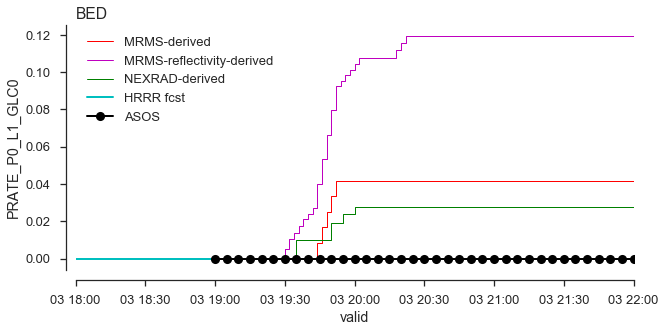

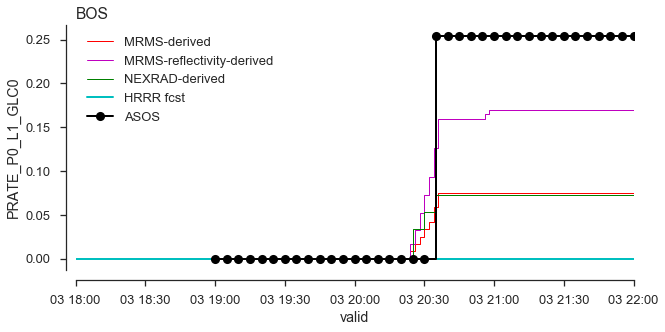

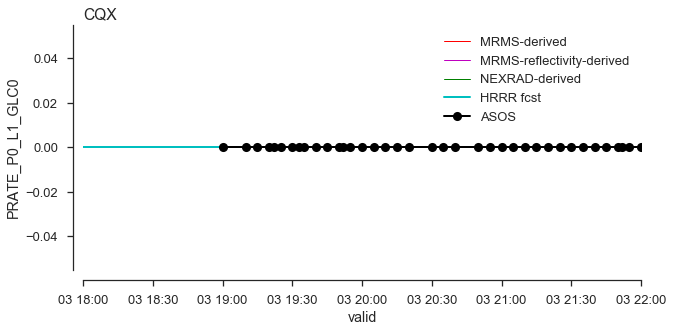

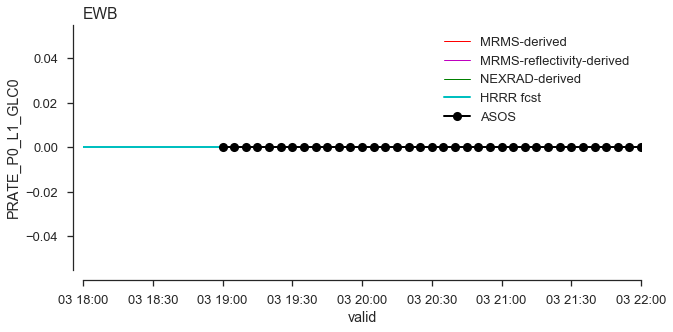

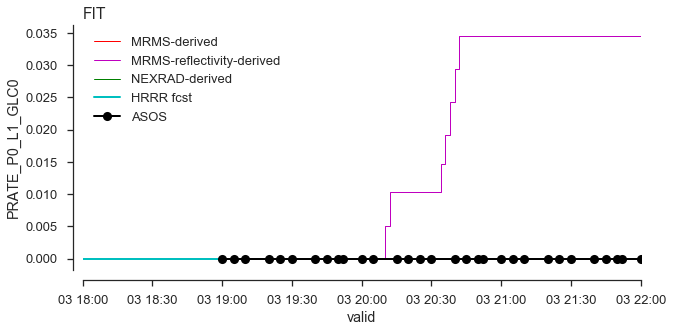

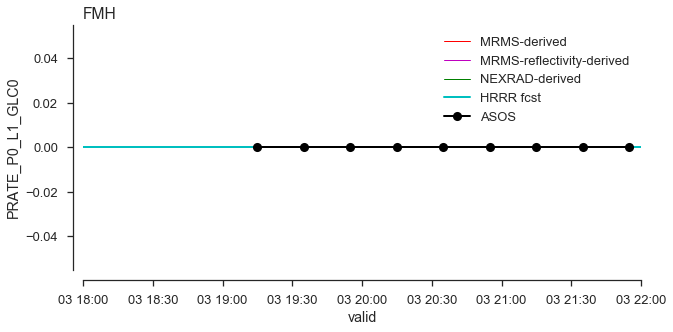

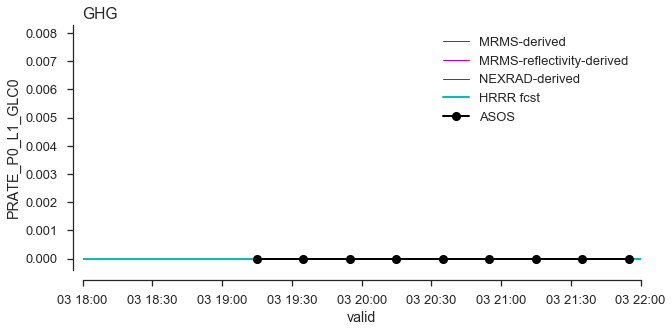

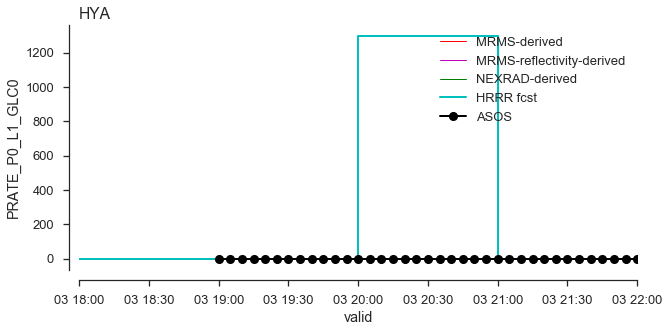

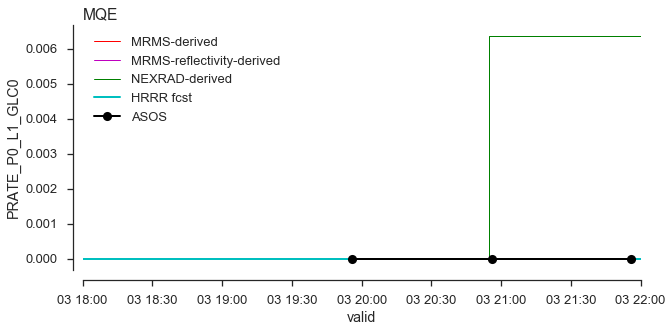

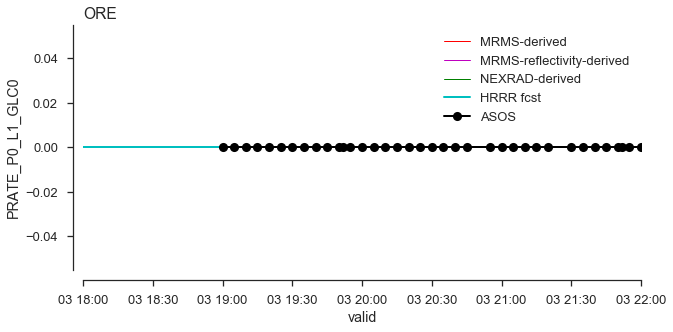

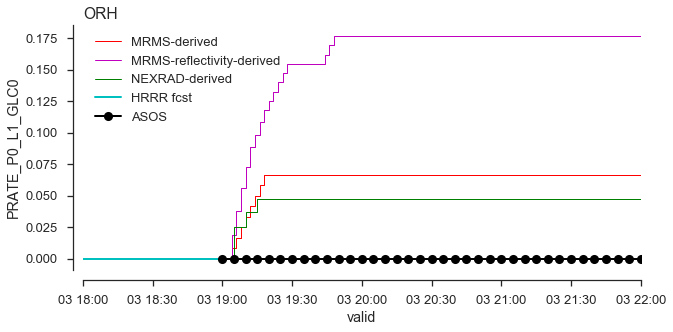

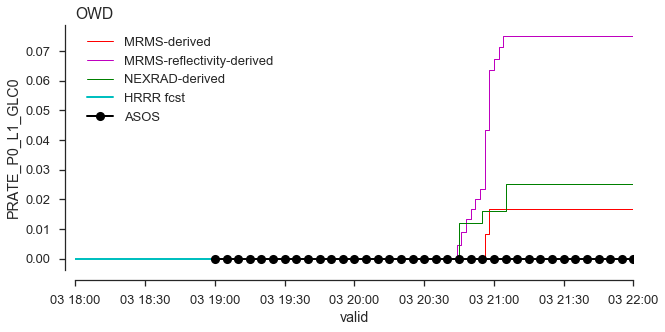

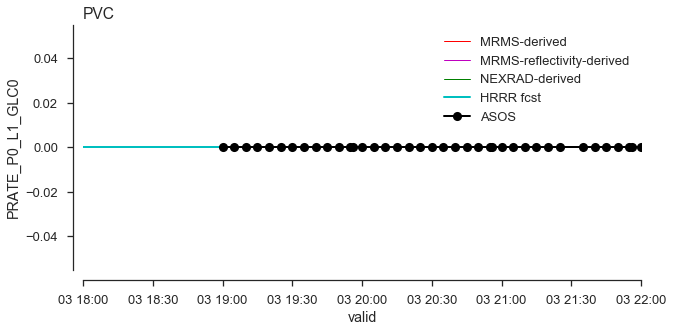

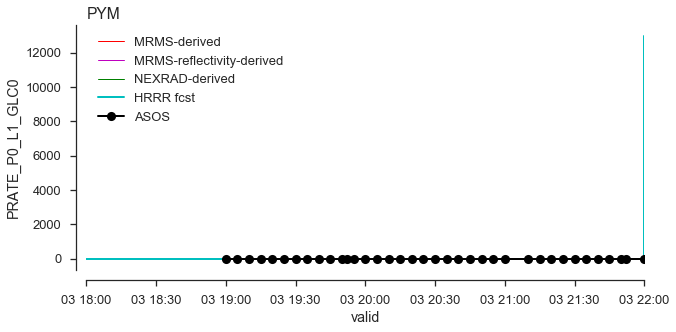

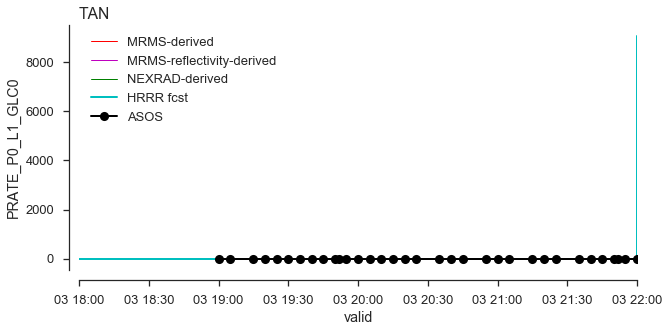

In [288]:
from ccpy.obs import accumulate_hourly_precip
from ccpy.plot import get_figsize

figsize = get_figsize(1, 1, 5., 2.)

t_begin = pd.Timestamp(2017, 11, 3, 19)
t_end = pd.Timestamp(2017, 11, 3, 22)
t_range = pd.date_range(t_begin, t_end, freq='300S')

stations = obs.index.levels[0]
for stid in stations:
    
    obs_st = obs.loc[stid]
    obs_st = obs_st.loc[obs_st.auto]
    obs_st = obs_st.loc[t_begin:t_end]
    lon, lat = obs_st.iloc[0][['lon', 'lat']]

    print(stid, lon, lat)

    a2m_st = a2m.sel(x=lon, y=lat, method='nearest').fillna(0).cumsum('time')
    # Correct for observation cadence, assuming constant intensity between obs
    a2m_st *= 120./3600.

    n0q_rate_st = n0q_rate.sel(x=lon, y=lat, method='nearest').fillna(0).cumsum('time')
    n0q_rate_st *= 120./3600.

    lcref_rate_st = lcref_rate.sel(x=lon, y=lat, method='nearest').fillna(0).cumsum('time')
    lcref_rate_st *= 120./3600.

    precip = obs_st.p01i
    precip_x = precip.fillna(0)
    obs_precip = accumulate_hourly_precip(precip_x) * 25.4
    
    dists = np.sqrt((lon2d - lon)**2 + (lat2d - lat)**2)
    min_flat_idx = dists.argmin()
    ilon, ilat = np.unravel_index(dists.argmin(), dists.shape)
    hrrr_precip = hrrr['PRATE_P0_L1_GLC0'].isel(fcst=0, xgrid_0=ilon, ygrid_0=ilat)
    hrrr_precip *= 3600.
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    a2m_st.plot(ax=ax, color='r', lw=1, drawstyle='steps-post', label='MRMS-derived')
    lcref_rate_st.plot(ax=ax, color='m', lw=1, drawstyle="steps-post",
                       label='MRMS-reflectivity-derived')
    n0q_rate_st.plot(ax=ax, color='g', lw=1, drawstyle='steps-post', label='NEXRAD-derived')
    hrrr_precip.plot(ax=ax, color='c', lw=2, drawstyle='steps-post', label='HRRR fcst')
    obs_precip.plot(ax=ax, color='k', lw=2, drawstyle='steps-post', marker='o', label='ASOS')
    ax.set_title("")
    ax.set_title(stid, loc='left')
    ax.legend(loc='best')
    
    sns.despine(ax=ax, offset=10)
    
    plt.savefig(case + "/figs/{}.precip.timeseries.pdf".format(stid))


Compare all the station records simultaneously:

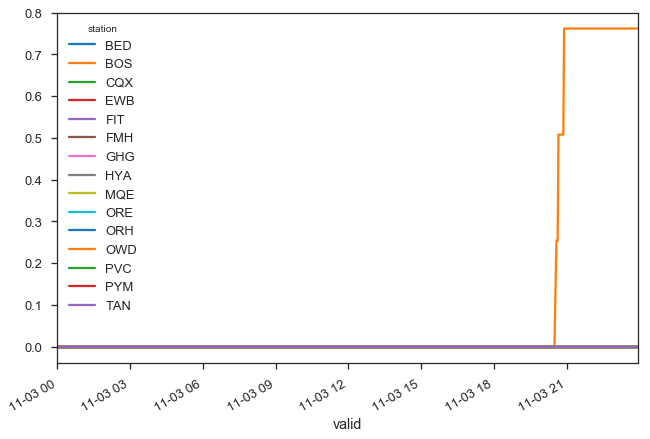

In [324]:
import seaborn as sns

obs_grid = obs.p01i.unstack(0).fillna(0)
obs_grid = obs_grid.apply(accumulate_hourly_precip) * 25.4
obs_grid.plot()

plt.savefig(case + "/figs/combined.precip.timeseries.pdf".format(stid))

So the only station that actual picked up measurable precipitation during this storm was at Logan. That's nigh-unbelievable, given my experience that evening, but the data is what the data is!

---

## Rain-rate timeseries

A fundamental assumption of the "amplitude tracking" extension for the nowcasting model is the idea that the local, transient timeseries of precipitation at any location over which a storm system passes is similar in a fractal sense. That is, the timeseries at two locations should be comparable under "stretching" in both time and amplitude.

Here, we try to evaluate that assumption using the available radar-derived precipitation rate data.

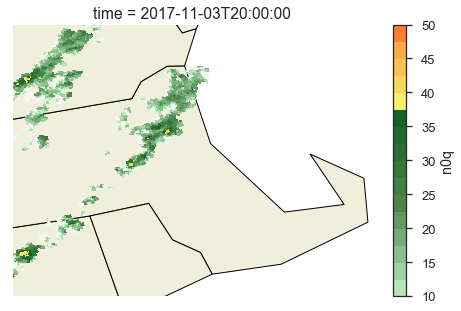

In [8]:
from ccpy.obs import n0q_to_refl
from ccpy.plot import make_precip_colormap, usa_states_ax

import matplotlib.animation as manimation
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

ds = xr.open_dataset("data/boston_nov_3/n0q.subset.nc").squeeze()
ds = ds.drop('band')
n0q_refl = n0q_to_refl(ds.n0q)

ax = usa_states_ax()
# tiles = cimgt.OSM()
# ax = plt.axes(projection=tiles.crs)
ax.set_extent([-72, -70, 41.5, 43.])
# ax.set_extent([ds.x.min(), ds.x.max(), ds.y.min(), ds.y.max()])
# ax.add_image(tiles, 8)

cmap_kws = make_precip_colormap('rain', 'refl', extend='neither')
ax = n0q_refl.isel(time=10).plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), zorder=100, 
    infer_intervals=True, **cmap_kws
)

Calculate rainfall rate from reflectivity using the Marshall-Palmer distribution.

In [9]:
from ccpy.atm_sci.raindists import marshall_palmer, dbz_to_z

n0q_rate = marshall_palmer(dbz_to_z(n0q_refl)) * 120./3600. * 25.4
n0q_rate.attrs['units'] = 'in/hr'

Just as a sanity check, plot the distribution of rainfall rates for one step. Generally speaking, this should be an exponential distribution.

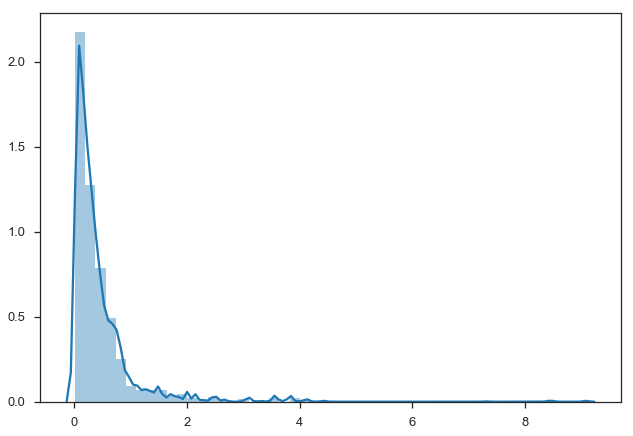

In [10]:
x = n0q_rate.isel(time=0).data.ravel()
sns.distplot(x[~np.isnan(x)])

Filter out grid cells where no rain was observed.

In [11]:
yy = n0q_rate.fillna(0).stack(cell=['x','y'])#.cumsum('time') * 3600. / 120.
yv = yy.values

# Filter 
yv_filt = yv[:, np.sum(yv, axis=0) > 0]
print(yv.shape, "->", yv_filt.shape)

(32, 641601) -> (32, 198411)


## Rain-rate Composites

Now, we want to composite the transient evolution of rainfall passing each gridcell, as we observed in the observations. To do this, we'll extract, re-scale, and composite runs of rainfall in our dataset. 

Ideally we want to observe a time-scale invariant rainfall timeseries. That is, we want to fit a general function that can be stretched or compressed based on how fast a storm system is moving.

To begin, we extract all the runs of precipitation greater than some minimum number of timesteps from our data

In [177]:
from itertools import groupby, chain

MIN_RUN_LENGTH = 5

all_runs = []
for a in yv_filt.T:
    runs = [ list(x[1]) for x in groupby(a, lambda x: x == 0) if not x[0] ]
    runs = [ r for r in runs if len(r) > MIN_RUN_LENGTH ]
    all_runs.extend(runs)

Just as a sanity check, this is the distribution of the length of these runs...

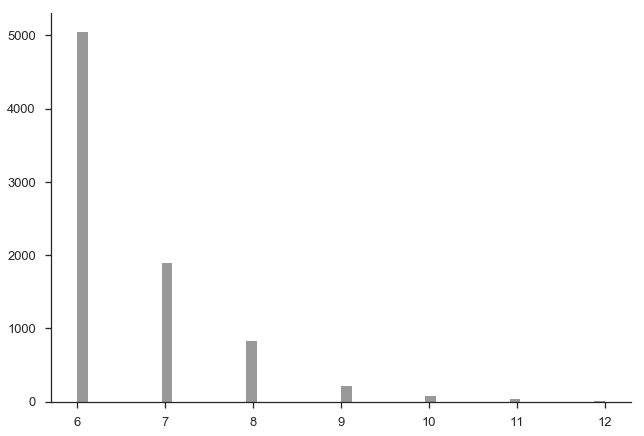

In [178]:
lens = [len(r) for r in all_runs]
ax = sns.distplot(lens, kde=False, color='k', )
sns.despine(ax=ax)

Our longest run is 12 timesteps long (for the n0q data, that's 60 minutes). To re-scale these runs with respect to time, we'll fit them to a time variable $\tau$ which runs from [0, 1].

Here's an example of fitting such a scaling:

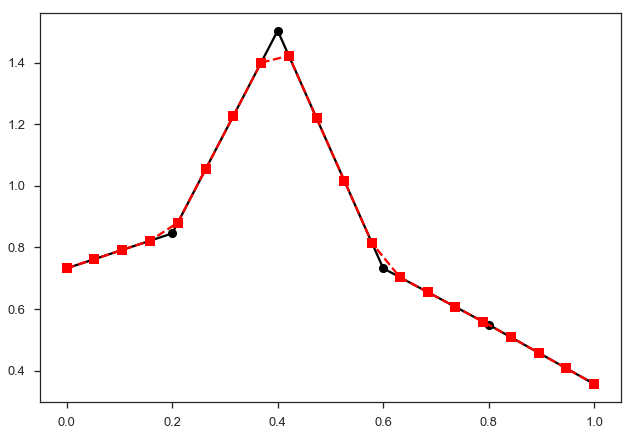

In [145]:
i = np.random.randint(0, len(all_runs))
# i = 5032
run = all_runs[i]

def fit_run(run, fit_len=20):

    n = len(run)
    idx = np.linspace(0, 1, n)

    x_fit = np.linspace(0, 1, fit_len)
    y_fit = np.interp(x_fit, idx, run)

    return y_fit

fit_len = 20
x_fit = np.linspace(0, 1, fit_len)
y_fit = fit_run(run, fit_len)
    
plt.plot(idx, run, 'ko-')
plt.plot(x_fit, y_fit, 'rs--')

We then apply this function to every single run in our dataset, finishing the composite.

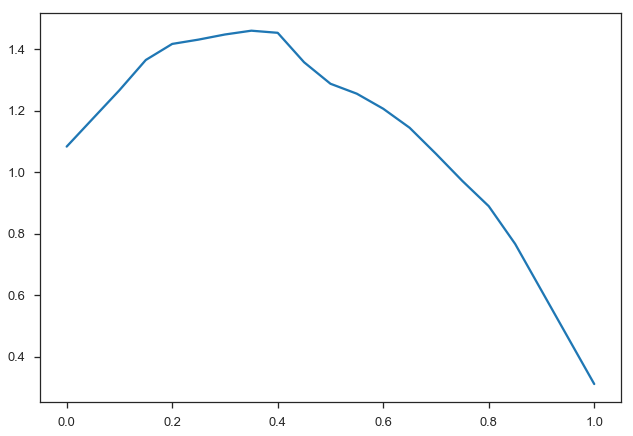

In [159]:
x_fit = np.linspace(0, 1, 21)
interp_runs = np.asarray([fit_run(run, 21) for run in all_runs]).T
plt.plot(x_fit, interp_runs.mean(axis=1))

interp_df = pd.DataFrame(interp_runs, index=pd.Index(x_fit, name='τ'))

Plot the average composite, with error bars.

/Users/daniel/anaconda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


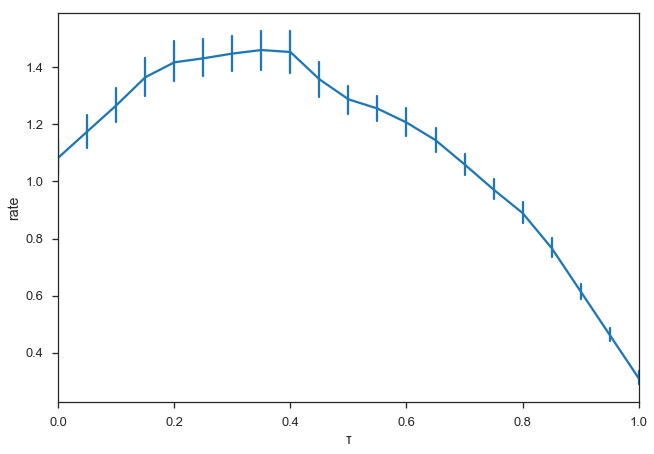

In [186]:
proc_df = (
    interp_df
    .stack()
    .reset_index()
    #.set_index('τ')
    .rename(columns={'level_1': 'cell', 0: 'rate'})
)
proc_df.head()

sns.tsplot(proc_df, time='τ', unit='cell', value='rate',
           n_boot=5000, ci=[1., 99.], err_style='ci_bars'
           # err_style='unit_traces'
)

Distribution of rain-rates as a function of time (in logarithmic space for easier viewing).

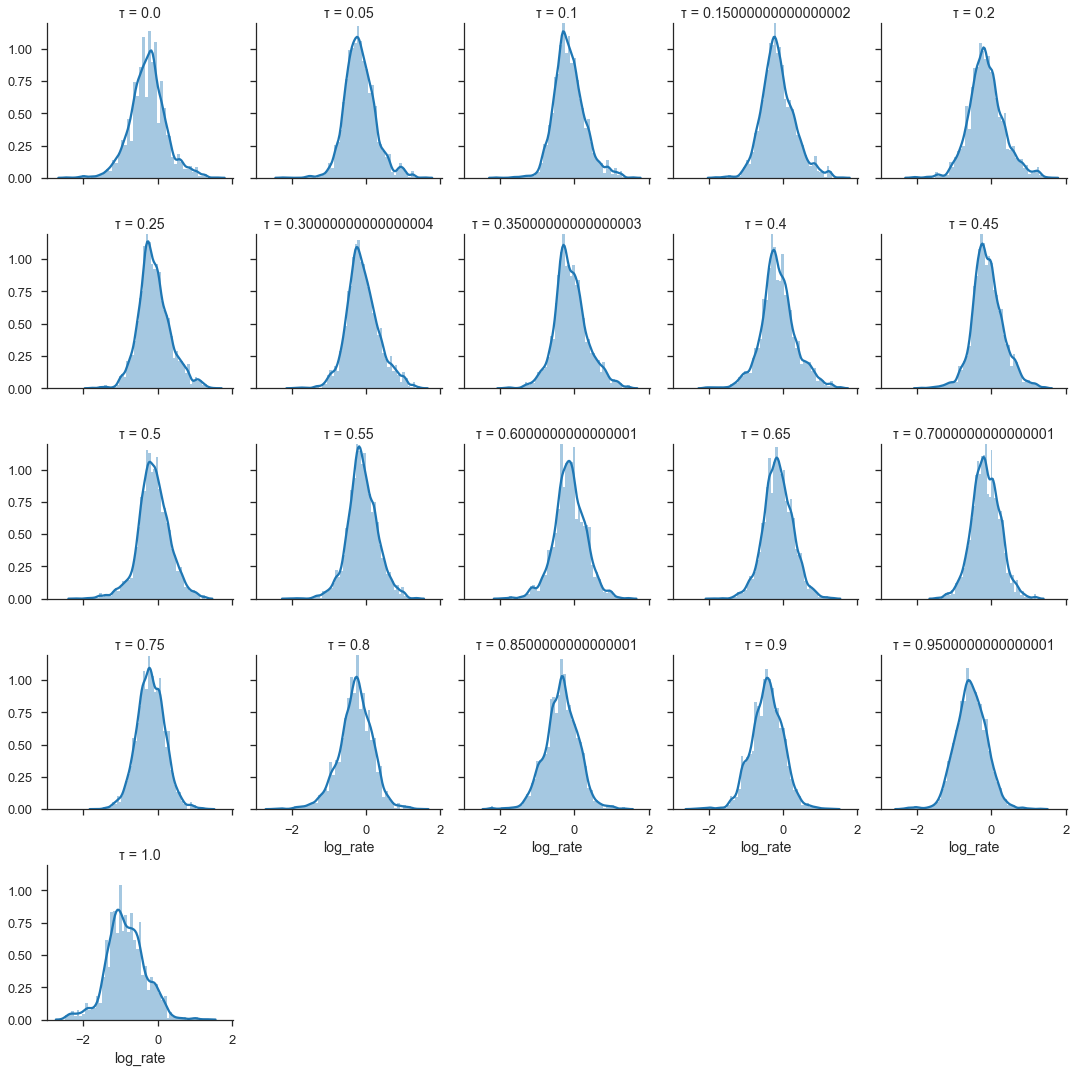

In [193]:
proc_df['log_rate'] = np.log10(proc_df['rate'])
fg = sns.FacetGrid(proc_df, col='τ', col_wrap=5)
fg.map(sns.distplot, 'log_rate')
# for ax in fg.axes.flatten():
#     ax.semilogx()

What's weird is that these are very log-normally distributed... that information might be useful when it comes to fitting the maximal rain rate.

In [252]:
xf2 = x_fit.copy()
xf2[0] = 1e-5
gamma_dist(xf2, 0.001, 1/0.5)

array([  9.89828696e+01,   2.20652965e-02,   1.22014165e-02,
         8.99341287e-03,   7.45658858e-03,   6.59411515e-03,
         6.07412759e-03,   5.75484347e-03,   5.56581810e-03,
         5.46835986e-03,   5.43969816e-03,   5.46579020e-03,
         5.53772817e-03,   5.64980863e-03,   5.79843359e-03,
         5.98145549e-03,   6.19777247e-03,   6.44707121e-03,
         6.72966050e-03,   7.04636261e-03,   7.39844276e-03])

In [287]:
gengamma_dist(0.5, 2, 0.5, 0.5)

(0.4387912809451864+0.2397127693021015j)

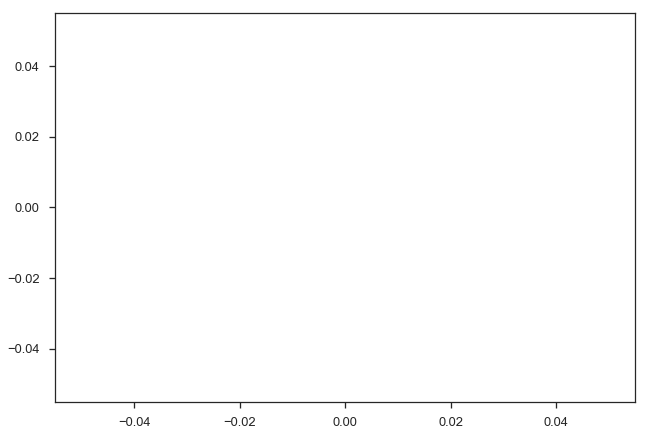

In [285]:
plt.plot(x_fit, gengamma_dist(x_fit, a=2, d=0.5, p=0.5))

In [ ]:
g

In [284]:
from lmfit import Model, Parameters
from scipy.special import gamma

params = Parameters()

def gamma_dist(x, alpha=9.0, theta=0.5):
    beta = 1./theta
    return (beta**alpha)*(x**(alpha-1))*(np.e**(beta*x))/gamma(alpha)
# params.add('alpha', value=3., min=0., max=5.)
# params.add('theta', value=5, min=1., max=10.)

def gengamma_dist(x, a, d, p):
    return (p/(a**d))*(x**(d-1))*(np.e**((-x/a)**p))/gamma(d/p)
params.add('a', min=1e-5)
params.add('d', min=1e-5)
params.add('p', min=1e-5)

xf2 = x_fit.copy()
xf2[0] = 1e-5

gmodel = Model(gengamma_dist)

print(params)

ir_scaled = interp_runs / interp_runs.max(axis=0)
result = gmodel.fit(ir_scaled[1:].T, params, x=xf2, verbose=True)

print(result.fit_report())
plt.plot(x_fit, ir_scaled.T.mean(axis=0))#interp_runs.T.mean(axis=0))
plt.plot(x_fit, result.init_fit, 'k--')
plt.plot(x_fit, result.best_fit, 'r-')


Parameters([('a', <Parameter 'a', 1e-05, bounds=[1e-05:inf]>), ('d', <Parameter 'd', 1e-05, bounds=[1e-05:inf]>), ('p', <Parameter 'p', 1e-05, bounds=[1e-05:inf]>)])


ValueError: operands could not be broadcast together with shapes (21,) (8105,20) 

In [216]:
gamma_dist(1)

0.093829283795944754

In [208]:
x_fit

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ])